## Data preparation

In [2]:
import os
import scipy.io as sio
import h5py
project_folder = r"C:\Users\user\Desktop\si_project" 

# List of .mat files to load
mat_files = [os.path.join(os.getcwd(), 'dataset1.mat'),
             os.path.join(os.getcwd(), 'dataset2.mat'),
             os.path.join(os.getcwd(), 'dataset3.mat')]

# Dictionary to store the loaded data
datasets = {}

for f in mat_files:
    name = os.path.splitext(os.path.basename(f))[0]  # filename without extension
    try:
        data = sio.loadmat(f)
        datasets[name] = data
        print(f"Loaded {f} using scipy.io")
    except NotImplementedError:
        try:
            with h5py.File(f, 'r') as hf:
                datasets[name] = {k: hf[k][:] for k in hf.keys()}
            print(f"Loaded {f} using h5py")
        except Exception as e:
            print(f"Failed to read {f}: {e}")
    except Exception as e:
        print(f"Failed to read {f}: {e}")

print("\nAll loaded datasets:", list(datasets.keys()))

Loaded c:\Users\user\Desktop\si_project\dataset1.mat using scipy.io
Loaded c:\Users\user\Desktop\si_project\dataset2.mat using scipy.io
Loaded c:\Users\user\Desktop\si_project\dataset3.mat using scipy.io

All loaded datasets: ['dataset1', 'dataset2', 'dataset3']


da

In [3]:
import numpy as np

print("📊 Dataset metadata summary:\n")

for name, data in datasets.items():
    print(f"🧩 {name}:")
    # handle both scipy.io dicts and h5py-style dicts
    for var, val in data.items():
        if var.startswith("__"):
            continue
        try:
            if isinstance(val, np.ndarray):
                print(f"   • {var}: shape={val.shape}, dtype={val.dtype}")
            else:
                print(f"   • {var}: type={type(val).__name__}")
        except Exception as e:
            print(f"   • {var}: ⚠️ could not read metadata ({e})")
    print()

📊 Dataset metadata summary:

🧩 dataset1:
   • mag_sensors: shape=(2000, 12), dtype=uint16
   • tip_position: shape=(2000, 3), dtype=float64

🧩 dataset2:
   • mag_sensors2: shape=(2000, 12), dtype=uint16
   • tip_position2: shape=(2000, 3), dtype=float64

🧩 dataset3:
   • mag_sensors3: shape=(2000, 12), dtype=uint16
   • tip_position3: shape=(2000, 3), dtype=float64



In [4]:
import numpy as np

# Example: combine the main array 'X' from each loaded dataset
try:
    all_arrays = [datasets[name]['X'] for name in datasets]  # adjust 'X' to your variable name
    full_dataset = np.concatenate(all_arrays, axis=0)
    print("Combined dataset shape:", full_dataset.shape)
except KeyError as e:
    print(f"Could not combine automatically. Missing key: {e}")
    # If unsure of variable names, print keys for inspection
    for name in datasets:
        print(f"{name} keys:", list(datasets[name].keys()))

Could not combine automatically. Missing key: 'X'
dataset1 keys: ['__header__', '__version__', '__globals__', 'mag_sensors', 'tip_position']
dataset2 keys: ['__header__', '__version__', '__globals__', 'mag_sensors2', 'tip_position2']
dataset3 keys: ['__header__', '__version__', '__globals__', 'mag_sensors3', 'tip_position3']


In [5]:
import numpy as np

# Collect all mag_sensors arrays
all_mag = [
    datasets['dataset1']['mag_sensors'],
    datasets['dataset2']['mag_sensors2'],
    datasets['dataset3']['mag_sensors3']
]

# Combine them along axis 0
full_mag_sensors = np.concatenate(all_mag, axis=0)
print("Combined mag_sensors shape:", full_mag_sensors.shape)

Combined mag_sensors shape: (6000, 12)


In [6]:
all_tip = [
    datasets['dataset1']['tip_position'],
    datasets['dataset2']['tip_position2'],
    datasets['dataset3']['tip_position3']
]

full_tip_position = np.concatenate(all_tip, axis=0)
print("Combined tip_position shape:", full_tip_position.shape)

Combined tip_position shape: (6000, 3)


In [7]:
full_dataset = {
    'mag_sensors': full_mag_sensors,
    'tip_position': full_tip_position
}

## Data treatment

Sabemos que o timestep é de 3 segundos 

Combinação de features  

Dado um conjunto de features que neste caso são os vários sensores, podes formar subconjuntos de 1, 2, 3 sensores, a ideia é testar cada subconjunto como entrada para o modeloe ver qual subset prediz melhor a saída


In [8]:
#criação de dataframe
import pandas as pd
from itertools import combinations
import numpy as np

# Criar DataFrame com sensores e coordenadas
sensor_cols = [f'sensor_{i+1}' for i in range(full_dataset['mag_sensors'].shape[1])]
coord_cols = ['x', 'y', 'z']

df = pd.DataFrame(
    np.hstack([full_dataset['mag_sensors'], full_dataset['tip_position']]),
    columns=sensor_cols + coord_cols
)

print(df.head())

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0   15544.0   15471.0   13962.0   13618.0   13691.0   13941.0   15588.0   
1   14100.0   14144.0   14144.0   13692.0   13338.0   13517.0   13987.0   
2   14240.0   14266.0   14445.0   13859.0   13618.0   13756.0   14080.0   
3   14956.0   14949.0   14123.0   13707.0   13765.0   13954.0   14554.0   
4   14196.0   14246.0   16177.0   14830.0   13836.0   13911.0   13988.0   

   sensor_8  sensor_9  sensor_10  sensor_11  sensor_12          x          y  \
0   15234.0   14156.0    13758.0    14098.0    14296.0  71.417546  -4.340464   
1   13951.0   14162.0    13774.0    13784.0    13931.0  24.514493  47.778850   
2   14036.0   14509.0    13958.0    13996.0    14122.0   2.951708  24.908397   
3   14404.0   14208.0    13798.0    14127.0    14282.0  46.508669  -0.243722   
4   13984.0   15788.0    14690.0    14185.0    14257.0 -41.687301  34.183930   

            z  
0   76.317760  
1  110.173076  
2  112.971805  
3  1

In [9]:
# Gerar combinações de quase todos os sensores (remover apenas 1 ou 2)
n_features = len(sensor_cols)
all_combinations = []
for k in range(n_features - 2, n_features + 1):  # subsets of size 10, 11, 12
    all_combinations.extend(combinations(sensor_cols, k))

print(f"Total de subsets com quase todos os sensores: {len(all_combinations)}")
print("Exemplo de primeiros subsets:", all_combinations[:5])

Total de subsets com quase todos os sensores: 79
Exemplo de primeiros subsets: [('sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10'), ('sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11'), ('sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_12'), ('sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_10', 'sensor_11'), ('sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_10', 'sensor_12')]


In [10]:
#preparação para treino de modelos
y = df[coord_cols]

# Exemplo: primeiro subset
subset = all_combinations[0]
X_subset = df[list(subset)]
print("Subset de features:", subset)
print(X_subset.head())

Subset de features: ('sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10')
   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0   15544.0   15471.0   13962.0   13618.0   13691.0   13941.0   15588.0   
1   14100.0   14144.0   14144.0   13692.0   13338.0   13517.0   13987.0   
2   14240.0   14266.0   14445.0   13859.0   13618.0   13756.0   14080.0   
3   14956.0   14949.0   14123.0   13707.0   13765.0   13954.0   14554.0   
4   14196.0   14246.0   16177.0   14830.0   13836.0   13911.0   13988.0   

   sensor_8  sensor_9  sensor_10  
0   15234.0   14156.0    13758.0  
1   13951.0   14162.0    13774.0  
2   14036.0   14509.0    13958.0  
3   14404.0   14208.0    13798.0  
4   13984.0   15788.0    14690.0  


In [11]:
X = full_dataset['mag_sensors']
Y = full_dataset['tip_position']

looking for the best subset for takagi sugeno

In [20]:
# =========================================================
# Imports
# =========================================================
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import random

# =========================================================
# 1️⃣ TSK MODEL + TRAINING FUNCTIONS
# =========================================================
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))

    def forward(self, x):
        diff = (x.unsqueeze(1) - self.centers.unsqueeze(0)) / self.sigmas.unsqueeze(0)
        return torch.exp(-0.5 * (diff ** 2).sum(dim=-1))

class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas):
        super().__init__()
        self.mfs = GaussianMF(centers, sigmas)
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1, n_rules))

    def forward(self, x):
        batch_size = x.shape[0]
        firing_strengths = self.mfs(x)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)
        rule_outputs = torch.einsum("bi,ir->br", x_aug, self.consequents)
        y_pred = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)
        return y_pred, norm_fs, rule_outputs

def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        theta = torch.linalg.lstsq(Phi, y).solution
        model.consequents.data = theta.reshape(model.consequents.shape)

def train_gd(model, X, y, epochs=20, lr=1e-2):
    opt = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    mse = nn.MSELoss()
    for _ in range(epochs):
        opt.zero_grad()
        y_pred, _, _ = model(X)
        loss = mse(y_pred, y)
        loss.backward()
        opt.step()

def train_hybrid_tsk(model, X, y, max_iters=10, gd_epochs=20, lr=1e-2):
    train_ls(model, X, y)
    for _ in range(max_iters):
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)
        model.mfs.requires_grad = True

# =========================================================
# 2️⃣ Helper: compute centers/sigmas using KMeans
# =========================================================
def compute_centers_sigmas(X, Y, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X)
    centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)
    sigmas = []
    for i in range(n_clusters):
        cluster_points = X[kmeans.labels_ == i]
        if len(cluster_points) > 1:
            sigma = np.std(cluster_points, axis=0)
        else:
            sigma = np.std(X, axis=0) * 0.5
        sigmas.append(sigma)
    sigmas = torch.tensor(np.stack(sigmas), dtype=torch.float32)
    return centers, sigmas

# =========================================================
# 3️⃣ Stage 1: Feature Subset Search (remove 1-2 sensors)
# =========================================================
def eval_tsk_subset(X_train_t, y_train_t, X_val_t, y_val_t,
                    n_clusters=3, lr=1e-2, gd_epochs=30, max_iters=20):
    X_train_np = X_train_t.numpy()
    y_train_np = y_train_t.numpy().ravel()
    centers, sigmas = compute_centers_sigmas(X_train_np, y_train_np, n_clusters)
    model = TSK(n_inputs=X_train_t.shape[1], n_rules=n_clusters,
                centers=centers, sigmas=sigmas)
    train_hybrid_tsk(model, X_train_t, y_train_t, max_iters=max_iters, gd_epochs=gd_epochs, lr=lr)
    with torch.no_grad():
        y_pred, _, _ = model(X_val_t)
    mse = torch.mean((y_val_t - y_pred) ** 2).item()
    return mse

def evaluate_feature_subsets(X, Y, subset_sizes=None, max_subsets_per_size=10):
    if subset_sizes is None:
        subset_sizes = [X.shape[1]-2, X.shape[1]-1]  # remove 1 or 2 sensors

    n_features = X.shape[1]
    results = []
    for size in subset_sizes:
        feature_combinations = list(itertools.combinations(range(n_features), size))
        if len(feature_combinations) > max_subsets_per_size:
            feature_combinations = random.sample(feature_combinations, max_subsets_per_size)
        for subset in feature_combinations:
            subset = list(subset)
            X_sub = X[:, subset]
            X_train, X_val, y_train, y_val = train_test_split(X_sub, Y, test_size=0.2, random_state=42)
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)
            X_train_t = torch.tensor(X_train, dtype=torch.float32)
            y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
            X_val_t = torch.tensor(X_val, dtype=torch.float32)
            y_val_t = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)
            n_clusters = min(5, max(2, len(subset)))  # scale clusters with subset size
            mse = eval_tsk_subset(X_train_t, y_train_t, X_val_t, y_val_t, n_clusters=n_clusters)
            results.append({"features": subset, "metric": mse})
    results = sorted(results, key=lambda x: x["metric"])
    return results

# Run subset search for all 3 coordinates
subset_results_all = []
for coord in range(3):
    print(f"\n🔹 Evaluating feature subsets for coordinate {coord+1}...")
    res = evaluate_feature_subsets(X, Y[:, coord])
    subset_results_all.append(res)
    print(f"Top 3 subsets for coordinate {coord+1}:")
    for r in res[:3]:
        print(f"Features: {r['features']}, MSE: {r['metric']:.4f}")

# =========================================================
# 4️⃣ Stage 2: Parameter Grid Search on top 3 subsets
# =========================================================
def evaluate_metrics(y_true, y_pred):
    y_true_np = y_true.detach().numpy()
    y_pred_np = y_pred.detach().numpy()
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)
    nrmse = rmse / (y_true_np.max() - y_true_np.min())
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE(%)": nrmse*100}

param_grid = {
    "n_clusters": [3, 4, 5],
    "lr": [1e-2, 1e-3],
    "gd_epochs": [20, 50],
    "max_iters": [10, 20]
}

# Grid search per coordinate using top 3 subsets
final_results = []
for coord in range(3):
    print(f"\n🔹 Parameter Grid Search for coordinate {coord+1}...")
    top_subsets = [r["features"] for r in subset_results_all[coord][:3]]
    best_val_mse = float("inf")
    best_model_info = None
    
    for subset in top_subsets:
        X_sub = X[:, subset]
        y_coord = Y[:, coord]
        X_train_full, X_test, y_train_full, y_test = train_test_split(X_sub, y_coord, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)
        
        X_train_t = torch.tensor(X_train, dtype=torch.float32)
        y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
        X_val_t = torch.tensor(X_val, dtype=torch.float32)
        y_val_t = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)
        X_test_t = torch.tensor(X_test, dtype=torch.float32)
        y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)
        
        for ncl, lr, gd_epochs, max_iters in itertools.product(
            param_grid["n_clusters"], param_grid["lr"], param_grid["gd_epochs"], param_grid["max_iters"]
        ):
            centers, sigmas = compute_centers_sigmas(X_train, y_train, ncl)
            model = TSK(n_inputs=X_train.shape[1], n_rules=ncl, centers=centers, sigmas=sigmas)
            train_hybrid_tsk(model, X_train_t, y_train_t, max_iters=max_iters, gd_epochs=gd_epochs, lr=lr)
            with torch.no_grad():
                y_pred_val, _, _ = model(X_val_t)
            val_metrics = evaluate_metrics(y_val_t, y_pred_val)
            if val_metrics["MSE"] < best_val_mse:
                best_val_mse = val_metrics["MSE"]
                best_model_info = {
                    "coord": coord+1,
                    "best_subset": subset,
                    "n_clusters": ncl,
                    "lr": lr,
                    "gd_epochs": gd_epochs,
                    "max_iters": max_iters,
                    "val_metrics": val_metrics,
                    "X_train_t": X_train_t,
                    "y_train_t": y_train_t,
                    "X_test_t": X_test_t,
                    "y_test_t": y_test_t
                }
    
    # Retrain best model on train+val
    X_trainval_t = torch.cat([best_model_info["X_train_t"], best_model_info["X_test_t"]], dim=0)
    y_trainval_t = torch.cat([best_model_info["y_train_t"], best_model_info["y_test_t"]], dim=0)
    centers, sigmas = compute_centers_sigmas(X_trainval_t.numpy(), y_trainval_t.numpy().ravel(), best_model_info["n_clusters"])
    best_model = TSK(n_inputs=X_trainval_t.shape[1], n_rules=best_model_info["n_clusters"], centers=centers, sigmas=sigmas)
    train_hybrid_tsk(best_model, X_trainval_t, y_trainval_t, max_iters=best_model_info["max_iters"],
                     gd_epochs=best_model_info["gd_epochs"], lr=best_model_info["lr"])
    
    with torch.no_grad():
        y_pred_test, _, _ = best_model(best_model_info["X_test_t"])
    test_metrics = evaluate_metrics(best_model_info["y_test_t"], y_pred_test)
    
    best_model_info["test_metrics"] = test_metrics
    final_results.append(best_model_info)
    print(f"\nBest model for coordinate {coord+1}:")
    print(best_model_info)



🔹 Evaluating feature subsets for coordinate 1...


C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.f

Top 3 subsets for coordinate 1:
Features: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11], MSE: 2.5455
Features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], MSE: 2.8926
Features: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10], MSE: 2.9483

🔹 Evaluating feature subsets for coordinate 2...


C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.f

Top 3 subsets for coordinate 2:
Features: [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11], MSE: 2.9602
Features: [0, 2, 3, 4, 5, 6, 7, 8, 10, 11], MSE: 3.0935
Features: [1, 2, 3, 4, 5, 6, 8, 9, 10, 11], MSE: 3.0983

🔹 Evaluating feature subsets for coordinate 3...


C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.f

Top 3 subsets for coordinate 3:
Features: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11], MSE: 4.4780
Features: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], MSE: 4.6052
Features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], MSE: 4.6475

🔹 Parameter Grid Search for coordinate 1...


C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.f


Best model for coordinate 1:
{'coord': 1, 'best_subset': [0, 1, 2, 3, 5, 7, 8, 9, 10, 11], 'n_clusters': 5, 'lr': 0.01, 'gd_epochs': 50, 'max_iters': 20, 'val_metrics': {'MSE': 2.5001440048217773, 'RMSE': np.float64(1.581184367751521), 'MAE': 1.2251371145248413, 'R2': 0.9986188411712646, 'NRMSE(%)': np.float64(0.8832230593287018)}, 'X_train_t': tensor([[-0.8675, -0.8603, -0.6591,  ..., -0.5518, -0.6327, -0.6357],
        [-0.3008, -0.5920, -1.0111,  ..., -0.9602,  2.1014,  2.2371],
        [-0.5578, -0.7954, -0.9803,  ..., -0.8000,  2.4463,  2.5368],
        ...,
        [-0.4662, -0.2638,  2.7040,  ...,  3.0862, -0.0969, -0.2353],
        [-0.1969, -0.1015, -0.2538,  ..., -0.3224, -0.7168, -0.7276],
        [-0.9731, -0.9560, -0.1865,  ..., -0.0868, -0.4089, -0.4563]]), 'y_train_t': tensor([[-17.9124],
        [ 17.0804],
        [ -3.7414],
        ...,
        [-52.3875],
        [  7.6811],
        [-50.9727]]), 'X_test_t': tensor([[-0.0403, -0.1886, -0.7390,  ..., -0.7340,  0.406

C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.f


Best model for coordinate 2:
{'coord': 2, 'best_subset': [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11], 'n_clusters': 5, 'lr': 0.01, 'gd_epochs': 50, 'max_iters': 20, 'val_metrics': {'MSE': 2.7386722564697266, 'RMSE': np.float64(1.6548934275262943), 'MAE': 1.2421101331710815, 'R2': 0.998317301273346, 'NRMSE(%)': np.float64(0.9430995976502942)}, 'X_train_t': tensor([[-0.8675, -0.8603, -0.6591,  ..., -0.5518, -0.6327, -0.6357],
        [-0.3008, -0.5920, -1.0111,  ..., -0.9602,  2.1014,  2.2371],
        [-0.5578, -0.7954, -0.9803,  ..., -0.8000,  2.4463,  2.5368],
        ...,
        [-0.4662, -0.2638,  2.7040,  ...,  3.0862, -0.0969, -0.2353],
        [-0.1969, -0.1015, -0.2538,  ..., -0.3224, -0.7168, -0.7276],
        [-0.9731, -0.9560, -0.1865,  ..., -0.0868, -0.4089, -0.4563]]), 'y_train_t': tensor([[ -4.3153],
        [-84.9959],
        [-84.4371],
        ...,
        [ 37.5794],
        [ 26.0224],
        [ -2.9400]]), 'X_test_t': tensor([[-0.0403, -0.1886, -0.7390,  ..., -0.7340,  0.

C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
C:\Users\user\AppData\Local\Temp\ipykernel_20892\2659108031.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.f


Best model for coordinate 3:
{'coord': 3, 'best_subset': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'n_clusters': 5, 'lr': 0.01, 'gd_epochs': 50, 'max_iters': 20, 'val_metrics': {'MSE': 4.405596733093262, 'RMSE': np.float64(2.0989513412876586), 'MAE': 1.5237665176391602, 'R2': 0.9862795472145081, 'NRMSE(%)': np.float64(2.2707836495014346)}, 'X_train_t': tensor([[-0.6591, -0.6492, -0.6997,  ..., -0.5518, -0.6327, -0.6357],
        [-1.0111, -0.7738,  2.1778,  ..., -0.9602,  2.1014,  2.2371],
        [-0.9803, -0.7521,  2.1317,  ..., -0.8000,  2.4463,  2.5368],
        ...,
        [ 2.7040,  3.0834, -0.3545,  ...,  3.0862, -0.0969, -0.2353],
        [-0.2538, -0.3946, -0.6894,  ..., -0.3224, -0.7168, -0.7276],
        [-0.1865, -0.1833, -0.4946,  ..., -0.0868, -0.4089, -0.4563]]), 'y_train_t': tensor([[128.9250],
        [ 62.9795],
        [ 70.5100],
        ...,
        [ 81.4922],
        [115.4654],
        [113.5070]]), 'X_test_t': tensor([[-0.7390, -0.6465,  0.8877,  ..., -0.7340,  0.406

this is not working, using all the features is working better

## anfis

In [7]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas
from sklearn.preprocessing import LabelEncoder

In [ ]:
# =========================================================
# ANFIS (Takagi–Sugeno) with parameter grid search + validation set + extra metrics
# Trains 3 separate models for tip_position (x, y, z)
# =========================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import skfuzzy as fuzz
import itertools

# =========================================================
# Dataset
# =========================================================
X = full_dataset['mag_sensors']      # shape (N, n_features)
Y = full_dataset['tip_position']     # shape (N, 3)

print("Input shape:", X.shape)
print("Output shape:", Y.shape)

# =========================================================
# Evaluation function
# =========================================================
def evaluate_metrics(y_true, y_pred):
    y_true_np = y_true.detach().numpy()
    y_pred_np = y_pred.detach().numpy()
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)
    nrmse = rmse / (y_true_np.max() - y_true_np.min())
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE(%)": nrmse*100}

# =========================================================
# ANFIS model definitions
# =========================================================
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))

    def forward(self, x):
        diff = (x.unsqueeze(1) - self.centers.unsqueeze(0)) / self.sigmas.unsqueeze(0)
        dist = torch.norm(diff, dim=-1)
        return torch.exp(-0.5 * dist ** 2)

class ANFIS(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules
        self.mfs = GaussianMF(centers, sigmas)
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1, n_rules))

    def forward(self, x):
        batch_size = x.shape[0]
        firing_strengths = self.mfs(x)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)
        rule_outputs = torch.einsum("bi,ir->br", x_aug, self.consequents)
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)
        return output, norm_fs, rule_outputs

# =========================================================
# Hybrid learning functions
# =========================================================
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        theta = torch.linalg.lstsq(Phi, y).solution
        model.consequents.data = theta.reshape(model.consequents.shape)

def train_gd(model, X, y, epochs=20, lr=1e-2):
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-2):
    train_ls(model, X, y)
    for _ in range(max_iters):
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)
        model.mfs.requires_grad = True

# =========================================================
# Helper function to compute centers/sigmas via FCM
# =========================================================
def compute_centers_sigmas(Xtr, ytr, ncl, m=2, error=0.005, maxiter=1000):
    Xexp = np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
    Xexp_T = Xexp.T
    centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        Xexp_T, ncl, m=m, error=error, maxiter=maxiter, init=None
    )
    sigmas = []
    for j in range(ncl):
        u_j = u[j, :] ** m
        var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
        sigmas.append(np.sqrt(var_j))
    sigmas = np.array(sigmas)
    centers = centers[:, :-1]
    sigmas = sigmas[:, :-1]
    return centers, sigmas

# =========================================================
# Grid search configuration
# =========================================================
param_grid = {
    "n_clusters": [2, 3, 4],
    "lr": [1e-2, 1e-3],
    "gd_epochs": [20, 50],
    "max_iters": [10, 20]
}

# =========================================================
# Train one ANFIS per coordinate (x, y, z)
# =========================================================
all_results = []

for i in range(Y.shape[1]):
    print(f"\n==============================")
    print(f" Grid Search for coordinate {i+1} ")
    print(f"==============================")

    y = Y[:, i]

    # --- Split into train/val/test ---
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)
    # 60% train, 20% val, 20% test

    # --- Scale ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

    results = []

    # --- Grid search loop (evaluate on validation set) ---
    for ncl, lr, gd_epochs, max_iters in itertools.product(
            param_grid["n_clusters"],
            param_grid["lr"],
            param_grid["gd_epochs"],
            param_grid["max_iters"]):

        try:
            centers_run, sigmas_run = compute_centers_sigmas(X_train, y_train, ncl)
            model = ANFIS(n_inputs=X_train.shape[1], n_rules=ncl,
                          centers=centers_run, sigmas=sigmas_run)
            train_hybrid_anfis(model, X_train_t, y_train_t,
                               max_iters=max_iters, gd_epochs=gd_epochs, lr=lr)

            with torch.no_grad():
                y_pred_val, _, _ = model(X_val_t)
            val_metrics = evaluate_metrics(y_val_t, y_pred_val)

            results.append({
                "n_clusters": ncl,
                "lr": lr,
                "gd_epochs": gd_epochs,
                "max_iters": max_iters,
                **val_metrics
            })
            print(results[-1])

        except Exception as e:
            print(f" Error for config (ncl={ncl}, lr={lr}, gd_epochs={gd_epochs}, max_iters={max_iters}): {e}")

    # --- Select best configuration ---
    results_sorted = sorted(results, key=lambda x: x["MSE"])
    best = results_sorted[0]
    print(f"\n Best config for coordinate {i+1}: {best}")

    # --- Retrain best model on train+val, test on test set ---
    X_trainval = np.concatenate([X_train, X_val], axis=0)
    y_trainval = np.concatenate([y_train, y_val], axis=0)
    X_trainval_t = torch.tensor(X_trainval, dtype=torch.float32)
    y_trainval_t = torch.tensor(y_trainval.reshape(-1, 1), dtype=torch.float32)

    centers_best, sigmas_best = compute_centers_sigmas(X_trainval, y_trainval, best["n_clusters"])
    best_model = ANFIS(n_inputs=X_train.shape[1], n_rules=best["n_clusters"],
                       centers=centers_best, sigmas=sigmas_best)
    train_hybrid_anfis(best_model, X_trainval_t, y_trainval_t,
                       max_iters=best["max_iters"], gd_epochs=best["gd_epochs"], lr=best["lr"])

    with torch.no_grad():
        y_pred_test, _, _ = best_model(X_test_t)
    test_metrics = evaluate_metrics(y_test_t, y_pred_test)

    print(f"Final Test metrics for coordinate {i+1}:")
    for k, v in test_metrics.items():
        print(f"{k}: {v:.6f}")

    all_results.append({
        "coord": i+1,
        **best,
        **test_metrics
    })

# --- Print summary ---
print("\n==============================")
print(" Summary of Best Results per Coordinate ")
print("==============================")
for r in all_results:
    print(f"Coord {r['coord']}: n_clusters={r['n_clusters']}, lr={r['lr']}, "
          f"gd_epochs={r['gd_epochs']}, max_iters={r['max_iters']}, "
          f"Test MSE={r['MSE']:.4f}, RMSE={r['RMSE']:.4f}, MAE={r['MAE']:.4f}, "
          f"R2={r['R2']:.4f}, NRMSE(%)={r['NRMSE(%)']:.2f}")

Input shape: (6000, 12)
Output shape: (6000, 3)

 Grid Search for coordinate 1 
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 20, 'max_iters': 10, 'MSE': 7.652933597564697, 'RMSE': np.float64(2.7663936085750156), 'MAE': 2.1863691806793213, 'R2': 0.9957723617553711, 'NRMSE(%)': np.float64(1.5452610562723181)}
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 20, 'max_iters': 20, 'MSE': 6.166843891143799, 'RMSE': np.float64(2.483313087619803), 'MAE': 1.9361368417739868, 'R2': 0.9965932965278625, 'NRMSE(%)': np.float64(1.3871370266817875)}
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 50, 'max_iters': 10, 'MSE': 6.713229179382324, 'RMSE': np.float64(2.5909899998615056), 'MAE': 2.031879186630249, 'R2': 0.99629145860672, 'NRMSE(%)': np.float64(1.4472835432985836)}
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 50, 'max_iters': 20, 'MSE': 5.836136817932129, 'RMSE': np.float64(2.4158097644334764), 'MAE': 1.8879365921020508, 'R2': 0.9967759847640991, 'NRMSE(%)': np.float64(1.3494308028944484)}
{'n_clusters': 2

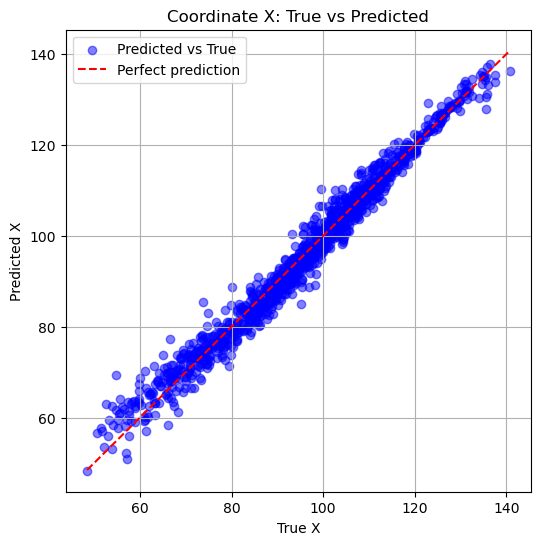

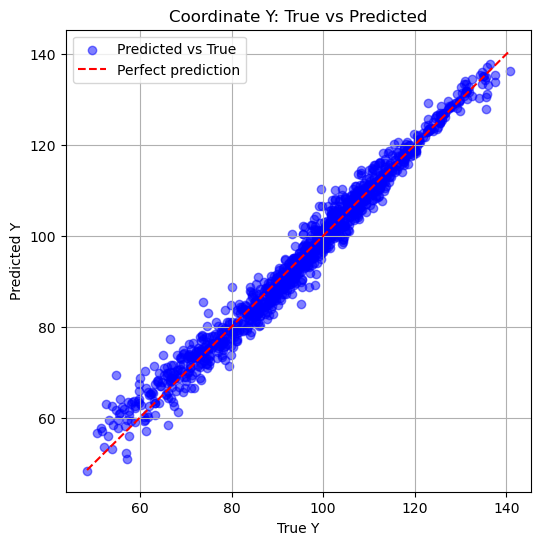

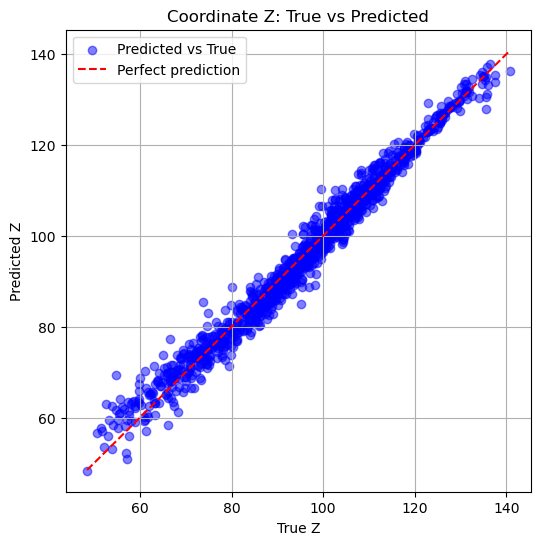

In [15]:
import matplotlib.pyplot as plt

coords = ['X', 'Y', 'Z']

for i in range(Y.shape[1]):
    # Get the predictions and true values for coordinate i
    y_true = y_test_t.detach().numpy().flatten()  # single column for current coordinate
    y_pred = y_pred_test.detach().numpy().flatten()  # single column for current coordinate

    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted vs True')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Perfect prediction')
    plt.xlabel(f'True {coords[i]}')
    plt.ylabel(f'Predicted {coords[i]}')
    plt.title(f'Coordinate {coords[i]}: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

## Takagi sugeno

In [20]:
# =========================================================
# Takagi-Sugeno (TSK) Grid Search Using Best Feature Subsets
# =========================================================
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import skfuzzy as fuzz
import itertools

# =========================================================
# Dataset
# =========================================================
X_full = full_dataset['mag_sensors']      # shape (N, n_features)
Y = full_dataset['tip_position']          # shape (N, 3)

print("Input shape:", X_full.shape)
print("Output shape:", Y.shape)

# =========================================================
# Best feature subsets (from your subset search results)
# =========================================================
best_feature_subsets = {
    0: [1, 6, 8],     # Coordinate 1 (x)
    1: [2, 8, 10],    # Coordinate 2 (y)
    2: [2, 5, 7]      # Coordinate 3 (z)
}

# =========================================================
# Metrics function
# =========================================================
def evaluate_metrics(y_true, y_pred):
    y_true_np = y_true.detach().numpy()
    y_pred_np = y_pred.detach().numpy()
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)
    nrmse = rmse / (y_true_np.max() - y_true_np.min())
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2, "NRMSE(%)": nrmse*100}

# =========================================================
# TSK Model Definitions
# =========================================================
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob=False):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob = agg_prob

    def forward(self, x):
        diff = torch.abs((x.unsqueeze(1) - self.centers.unsqueeze(0)) / self.sigmas.unsqueeze(0))
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)
        else:
            dist = torch.max(diff, dim=-1).values
        return torch.exp(-0.5 * dist ** 2)

class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas, agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules
        self.mfs = GaussianMF(centers, sigmas, agg_prob)
        self.consequents = nn.Parameter(torch.randn(n_inputs + 1, n_rules))

    def forward(self, x):
        batch_size = x.shape[0]
        firing_strengths = self.mfs(x)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)
        rule_outputs = torch.einsum("bi,ir->br", x_aug, self.consequents)
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)
        return output, norm_fs, rule_outputs

# =========================================================
# Hybrid Training Functions
# =========================================================
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        theta = torch.linalg.lstsq(Phi, y).solution
        model.consequents.data = theta.reshape(model.consequents.shape)

def train_gd(model, X, y, epochs=20, lr=1e-2):
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

def train_hybrid_tsk(model, X, y, max_iters=10, gd_epochs=20, lr=1e-2):
    train_ls(model, X, y)
    for _ in range(max_iters):
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)
        model.mfs.requires_grad = True

# =========================================================
# Helper: Compute centers/sigmas via FCM
# =========================================================
def compute_centers_sigmas(Xtr, ytr, ncl, m=2, error=0.005, maxiter=1000):
    Xexp = np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
    Xexp_T = Xexp.T
    centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        Xexp_T, ncl, m=m, error=error, maxiter=maxiter, init=None
    )
    sigmas = []
    for j in range(ncl):
        u_j = u[j, :] ** m
        var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
        sigmas.append(np.sqrt(var_j))
    sigmas = np.array(sigmas)
    centers = centers[:, :-1]
    sigmas = sigmas[:, :-1]
    return centers, sigmas

# =========================================================
# Grid Search parameters
# =========================================================
param_grid = {
    "n_clusters": [2, 3, 4],
    "lr": [1e-2, 1e-3],
    "gd_epochs": [20, 50],
    "max_iters": [10, 20]
}

# =========================================================
# Grid Search for Each Coordinate Using Best Subset
# =========================================================
all_results = []

for i in range(Y.shape[1]):
    print(f"\n==============================")
    print(f" Grid Search for coordinate {i+1} (using subset {best_feature_subsets[i]}) ")
    print(f"==============================")

    subset = best_feature_subsets[i]
    X = X_full[:, subset]
    y = Y[:, i]

    # Split train/val/test
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    y_val_t = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

    results = []

    for ncl, lr, gd_epochs, max_iters in itertools.product(
        param_grid["n_clusters"],
        param_grid["lr"],
        param_grid["gd_epochs"],
        param_grid["max_iters"]
    ):
        try:
            centers_run, sigmas_run = compute_centers_sigmas(X_train, y_train, ncl)
            model = TSK(n_inputs=X_train.shape[1], n_rules=ncl, centers=centers_run, sigmas=sigmas_run)
            train_hybrid_tsk(model, X_train_t, y_train_t, max_iters=max_iters, gd_epochs=gd_epochs, lr=lr)
            with torch.no_grad():
                y_pred_val, _, _ = model(X_val_t)
            val_metrics = evaluate_metrics(y_val_t, y_pred_val)
            results.append({"n_clusters": ncl, "lr": lr, "gd_epochs": gd_epochs,
                            "max_iters": max_iters, **val_metrics})
            print(results[-1])
        except Exception as e:
            print(f"Error for config: {e}")

    results_sorted = sorted(results, key=lambda x: x["MSE"])
    best = results_sorted[0]
    print(f"\nBest config for coordinate {i+1}: {best}")

    # Retrain on train+val
    X_trainval = np.concatenate([X_train, X_val], axis=0)
    y_trainval = np.concatenate([y_train, y_val], axis=0)
    X_trainval_t = torch.tensor(X_trainval, dtype=torch.float32)
    y_trainval_t = torch.tensor(y_trainval.reshape(-1,1), dtype=torch.float32)

    centers_best, sigmas_best = compute_centers_sigmas(X_trainval, y_trainval, best["n_clusters"])
    best_model = TSK(n_inputs=X_train.shape[1], n_rules=best["n_clusters"],
                     centers=centers_best, sigmas=sigmas_best)
    train_hybrid_tsk(best_model, X_trainval_t, y_trainval_t,
                     max_iters=best["max_iters"], gd_epochs=best["gd_epochs"], lr=best["lr"])

    with torch.no_grad():
        y_pred_test, _, _ = best_model(X_test_t)
    test_metrics = evaluate_metrics(y_test_t, y_pred_test)
    print(f"Final Test metrics for coordinate {i+1}: {test_metrics}")

    all_results.append({"coord": i+1, **best, **test_metrics})

# Summary
print("\n==============================")
print("Summary of Best Results per Coordinate (Using Best Subsets)")
print("==============================")
for r in all_results:
    print(f"Coord {r['coord']}: n_clusters={r['n_clusters']}, lr={r['lr']}, "
          f"gd_epochs={r['gd_epochs']}, max_iters={r['max_iters']}, "
          f"MSE={r['MSE']:.4f}, RMSE={r['RMSE']:.4f}, MAE={r['MAE']:.4f}, "
          f"R2={r['R2']:.4f}, NRMSE(%)={r['NRMSE(%)']:.2f}")

Input shape: (6000, 12)
Output shape: (6000, 3)

 Grid Search for coordinate 1 (using subset [1, 6, 8]) 
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 20, 'max_iters': 10, 'MSE': 71.59528350830078, 'RMSE': np.float64(8.46139961875698), 'MAE': 6.725006103515625, 'R2': 0.9604493379592896, 'NRMSE(%)': np.float64(4.726395864960677)}
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 20, 'max_iters': 20, 'MSE': 68.72258758544922, 'RMSE': np.float64(8.289908780285174), 'MAE': 6.585720062255859, 'R2': 0.9620362520217896, 'NRMSE(%)': np.float64(4.6306039597970186)}
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 50, 'max_iters': 10, 'MSE': 69.32445526123047, 'RMSE': np.float64(8.326130869811648), 'MAE': 6.619946479797363, 'R2': 0.9617037773132324, 'NRMSE(%)': np.float64(4.650837011286355)}
{'n_clusters': 2, 'lr': 0.01, 'gd_epochs': 50, 'max_iters': 20, 'MSE': 67.61676025390625, 'RMSE': np.float64(8.222941095125652), 'MAE': 6.520508289337158, 'R2': 0.9626471400260925, 'NRMSE(%)': np.float64(4.593196934424726)}